In [2]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import os
import rasterio
from rasterio.sample import sample_gen
from rasterio.enums import Resampling

# Charger le fichier Excel (nécessite le module 'openpyxl')
file_path = r"D:\UQTR\Automne 2024\Ouest\GNSS_glaciers\Hilda\roverRS+\Rover\hilda_rover_all.xlsx"
df = pd.read_excel(file_path, engine='openpyxl')

# Renommer la colonne '%' pour éviter les problèmes
df.rename(columns={'%': 'percent'}, inplace=True)

# Convertir certaines colonnes en type numérique
columns_to_convert = ['latitude', 'longitude', 'height', 'ns', 'sdn(m)', 'sde(m)', 'sdu(m)', 'sdne(m)', 'sdeu(m)', 'sdun(m)', 'age(s)', 'ratio']
for col in columns_to_convert:
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Vérifier les colonnes du DataFrame
print(df.columns)

# Supposons que les colonnes 'latitude' et 'longitude' existent dans le fichier
latitude_col = 'latitude'
longitude_col = 'longitude'

# Créer une géométrie de points à partir des colonnes de latitude et longitude
df['geometry'] = df.apply(lambda row: Point(row[longitude_col], row[latitude_col]), axis=1)

# Convertir en GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='geometry')

# Supprimer les colonnes de type non compatible pour éviter les erreurs avec le shapefile
columns_to_drop = ['percent']  # Ajouter d'autres colonnes si nécessaire
gdf.drop(columns=columns_to_drop, inplace=True)

# Définir le système de coordonnées (par exemple, WGS84)
gdf.set_crs(epsg=4326, inplace=True)

# Spécifier le répertoire de sortie pour sauvegarder le shapefile
output_dir = r'D:\UQTR\Automne 2024\Ouest\GNSS_glaciers\hilda\roverRS+\Rover'
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, 'rover_hilda_all.shp')

# Sauvegarder en tant que shapefile (limiter les noms de colonnes à 10 caractères)
gdf.columns = [col[:10] for col in gdf.columns]
gdf.to_file(output_path, driver='ESRI Shapefile')

print("Conversion en shapefile terminée avec succès.")

# Charger le shapefile généré
gdf = gpd.read_file(output_path)

# Convertir le fichier .tif en float 32 bits
dem_path = r"D:\UQTR\Automne 2024\Ouest\SRTM\SRTM_DEM_corrected6.tif"
dem_float32_path = r"D:\UQTR\Automne 2024\Ouest\SRTM\SRTM_DEM_corrected6_float32_2.tif"

# Ouvrir et convertir le .tif en float 32 bits
with rasterio.open(dem_path) as src:
    profile = src.profile
    profile.update(dtype=rasterio.float32)

    with rasterio.open(dem_float32_path, 'w', **profile) as dst:
        for i in range(1, src.count + 1):
            data = src.read(i, resampling=Resampling.nearest).astype(rasterio.float32)
            dst.write(data, i)

# Charger le DEM converti
with rasterio.open(dem_float32_path) as dem:
    # Extraire la hauteur du DEM pour chaque point du shapefile
    coords = [(x, y) for x, y in zip(gdf.geometry.x, gdf.geometry.y)]
    gdf['dem_heigh'] = [val[0] for val in dem.sample(coords)]

# Calculer la différence entre la hauteur mesurée et la hauteur du DEM
gdf['heigh_diff'] = gdf['height'] - gdf['dem_heigh']

# Sauvegarder le GeoDataFrame mis à jour (limiter les noms de colonnes à 10 caractères)
gdf.columns = [col[:10] for col in gdf.columns]
gdf.to_file(output_path, driver='ESRI Shapefile')

print("Extraction des données de hauteur du DEM et calcul de la différence terminés avec succès.")

Index(['percent', 'GPST', 'latitude', 'longitude', 'height', 'Q', 'ns',
       'sdn(m)', 'sde(m)', 'sdu(m)', 'sdne(m)', 'sdeu(m)', 'sdun(m)', 'age(s)',
       'ratio'],
      dtype='object')
Conversion en shapefile terminée avec succès.
Extraction des données de hauteur du DEM et calcul de la différence terminés avec succès.


C:\Users\thier\AppData\Local\Temp\ipykernel_58748\4212902541.py:17: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  {'geometry': [gdf_sorted.geometry.unary_union.convex_hull]},


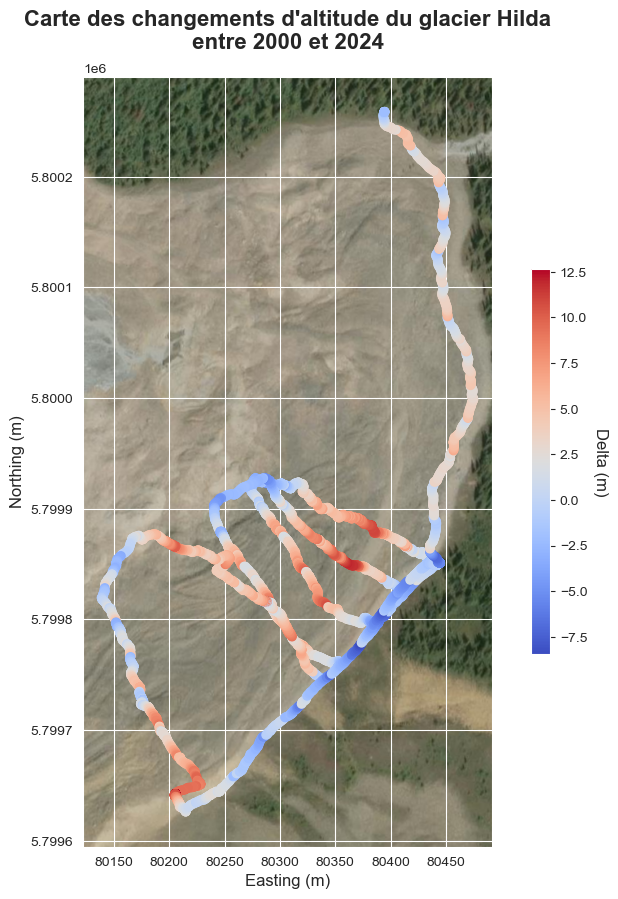

In [20]:
import geopandas as gpd
import matplotlib.pyplot as plt
import contextily as ctx

# Charger le fichier shapefile
# Le chemin d'accès au fichier shapefile contenant les données des points GNSS
gdf = gpd.read_file(r"D:\UQTR\Automne 2024\Ouest\GNSS_glaciers\Hilda\roverRS+\Rover\rover_hilda_all.shp")

# Convertir les points en lignes
# Trier les points par une colonne qui peut représenter l'ordre de la ligne, par exemple 'GPST' (données GPS temporelles)
gdf_sorted = gdf.sort_values('GPST')

# Créer une ligne à partir des points triés
# Utiliser 'unary_union' pour fusionner tous les points en une seule géométrie, puis prendre l'enveloppe convexe (convex hull) pour créer une ligne
# Cela est utile pour avoir une représentation générale des points en tant que ligne
gdf_line = gpd.GeoDataFrame(
    {'geometry': [gdf_sorted.geometry.unary_union.convex_hull]},
    crs=gdf.crs
)

# Créer une carte graduée pour représenter les changements d'altitude
# Reprojeter les données dans le système de coordonnées UTM (par exemple, EPSG:32612 pour UTM zone 12N)
gdf_sorted = gdf_sorted.to_crs(epsg=32612)

# Initialiser la figure et les axes pour la carte
fig, ax = plt.subplots(figsize=(10, 10))

# Tracer les lignes et utiliser la colonne 'heigh_diff' pour la couleur
# Représenter les différences d'altitude en utilisant un dégradé de couleurs (cmap='viridis')
gdf_sorted.plot(ax=ax, column='heigh_diff', cmap='coolwarm', legend=True, linewidth=1, legend_kwds={'shrink': 0.5})

# Ajouter une légende qui spécifie le delta en mètre
cbar = ax.get_figure().get_axes()[1]
cbar.set_ylabel('Delta (m)', rotation=270, labelpad=15, fontsize=12)

# Ajouter une basemap satellite pour donner un contexte géographique
ctx.add_basemap(ax, source=ctx.providers.Esri.WorldImagery, crs=gdf_sorted.crs, attribution="")
# Convertir les ticks des axes en coordonnées UTM
ax.set_xlabel("Easting (m)", fontsize=12)  # Étiquette de l'axe X en UTM avec taille de police
ax.set_ylabel("Northing (m)", fontsize=12)  # Étiquette de l'axe Y en UTM avec taille de police
ax.ticklabel_format(useOffset=False, style='scientific')  # Désactiver le décalage et afficher les coordonnées en style normal

# Afficher la carte avec le titre
plt.title("Carte des changements d'altitude du glacier Hilda\nentre 2000 et 2024", fontsize=16, fontweight='bold', pad=20)
plt.show()

In [7]:
# Ce script analyse les données d'élévation d'un Modèle Numérique de Terrain (MNT) en relation
# avec des points GPS. Il agrège les données par pixel du MNT, calcule des moyennes, et génère
# deux fichiers de sortie : un avec les données agrégées et un autre avec des altitudes uniques.
# Utile pour l'analyse topographique et la comparaison entre données GPS et MNT.

import numpy as np
import os
import rasterio
import geopandas as gpd

# Chemin vers le fichier MNT
dem_path = r"D:\UQTR\Automne 2024\Ouest\SRTM\SRTM_DEM_corrected6.tif"

# Chargement du MNT
with rasterio.open(dem_path) as dem:
    # Fonction pour mapper les points aux pixels du MNT
    def get_pixel(row, dem):
        col, row = dem.index(row.geometry.x, row.geometry.y)
        return row, col

    # Chargez ici votre GeoDataFrame 'gdf' si ce n'est pas déjà fait
    # gdf = gpd.read_file("chemin_vers_votre_shapefile.shp")

    # Assigner chaque point au pixel MNT correspondant
    gdf['dem_pixel'] = gdf.apply(lambda row: get_pixel(row, dem), axis=1)

    # Grouper par pixel MNT et calculer les moyennes
    gdf_grouped = gdf.groupby('dem_pixel').agg(
        mean_height=('height', 'mean'),
        mean_dem_height=('dem_height', 'mean'),
        mean_height_diff=('height_diff', 'mean'),
        point_count=('geometry', 'count')
    ).reset_index()

    # Renommer les colonnes (limite de 10 caractères pour Shapefile)
    gdf_grouped = gdf_grouped.rename(columns={
        'mean_height': 'mean_heig',
        'mean_dem_height': 'mean_dem',
        'mean_height_diff': 'mean_diff',
        'point_count': 'pt_count'
    })

    # Fusionner les données agrégées avec le GeoDataFrame original
    gdf = gdf.merge(gdf_grouped, on='dem_pixel', how='left')

# Répertoire de sortie
output_dir = r"D:\UQTR\Automne 2024\Ouest\GNSS_glaciers\Hilda\roverRS+\Rover"

# Sauvegarder les données agrégées
output_path_aggregated = os.path.join(output_dir, 'rover_hilda_aggregated.shp')
gdf.to_file(output_path_aggregated, driver='ESRI Shapefile')

# Garder seulement les points avec des altitudes MNT uniques
gdf_unique_dem = gdf.drop_duplicates(subset=['dem_height'])

# Sauvegarder le GeoDataFrame avec les altitudes MNT uniques
output_path_unique = os.path.join(output_dir, 'rover_hilda_unique_dem.shp')
gdf_unique_dem.to_file(output_path_unique, driver='ESRI Shapefile')

print("Agrégation par pixel MNT et calcul des moyennes terminés avec succès.")
print("GeoDataFrame avec les altitudes MNT uniques sauvegardé avec succès.")

Aggregation by DEM pixel and calculation of means completed successfully.
GeoDataFrame with unique DEM altitudes saved successfully, if applicable.


                            OLS Regression Results                            
Dep. Variable:              mean_diff   R-squared:                       0.011
Model:                            OLS   Adj. R-squared:                 -0.015
Method:                 Least Squares   F-statistic:                    0.4401
Date:                Tue, 08 Oct 2024   Prob (F-statistic):              0.511
Time:                        17:02:20   Log-Likelihood:                -113.56
No. Observations:                  40   AIC:                             231.1
Df Residuals:                      38   BIC:                             234.5
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    -58.7511     92.018     -0.638      0.5

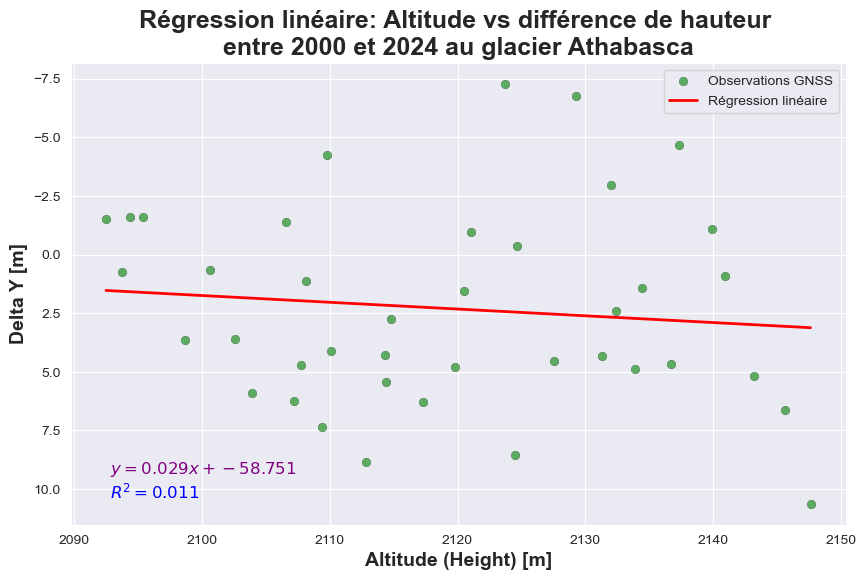

In [10]:
# Ce script analyse la relation entre l'altitude et la différence de hauteur
# pour le glacier Hilda entre 2000 et 2024. Il effectue une régression linéaire,
# affiche les résultats statistiques et crée un graphique de la relation.

import geopandas as gpd
import statsmodels.api as sm
from statsmodels.formula.api import ols
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Chargement des données
shapefile_path = r"D:\UQTR\Automne 2024\Ouest\GNSS_glaciers\Athabasca\roverRS+\Rover\rover_hilda_unique_dem.shp"
gdf = gpd.read_file(shapefile_path)

# Régression linéaire
model = ols('mean_diff ~ mean_heig', data=gdf).fit()
print(model.summary())

# Génération des valeurs pour la ligne de régression
x = np.linspace(gdf['mean_heig'].min(), gdf['mean_heig'].max(), 500)
x_df = gpd.GeoDataFrame({'mean_heig': x})
y_pred = model.predict(exog=x_df)

# Configuration du style du graphique
sns.set_style("darkgrid")
plt.figure(figsize=(10, 6))

# Tracé des données et de la ligne de régression
sns.scatterplot(x='mean_heig', y='mean_diff', data=gdf, alpha=0.6, color='g', s=40, label='Observations GNSS', edgecolor='black', linewidth=0.2)
plt.plot(x, y_pred, color='r', linestyle='-', linewidth=2, label='Régression linéaire')

# Ajout des informations statistiques
r_squared = model.rsquared
intercept = model.params['Intercept']
slope = model.params['mean_heig']
plt.text(0.05, 0.05, f'$R^2 = {r_squared:.3f}$', transform=plt.gca().transAxes, fontsize=12, fontweight='bold', color='blue', verticalalignment='bottom')
plt.text(0.05, 0.10, f'$y = {slope:.3f}x + {intercept:.3f}$', transform=plt.gca().transAxes, fontsize=12, fontweight='bold', color='purple', verticalalignment='bottom')

# Paramètres du graphique
plt.xlabel('Altitude (Height) [m]', fontsize=14, fontweight='bold')
plt.ylabel('Delta Y [m]', fontsize=14, fontweight='bold')
plt.title('Régression linéaire: Altitude vs différence de hauteur \nentre 2000 et 2024 au glacier Hilda', fontsize=18, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True)
plt.gca().invert_yaxis()

plt.show()

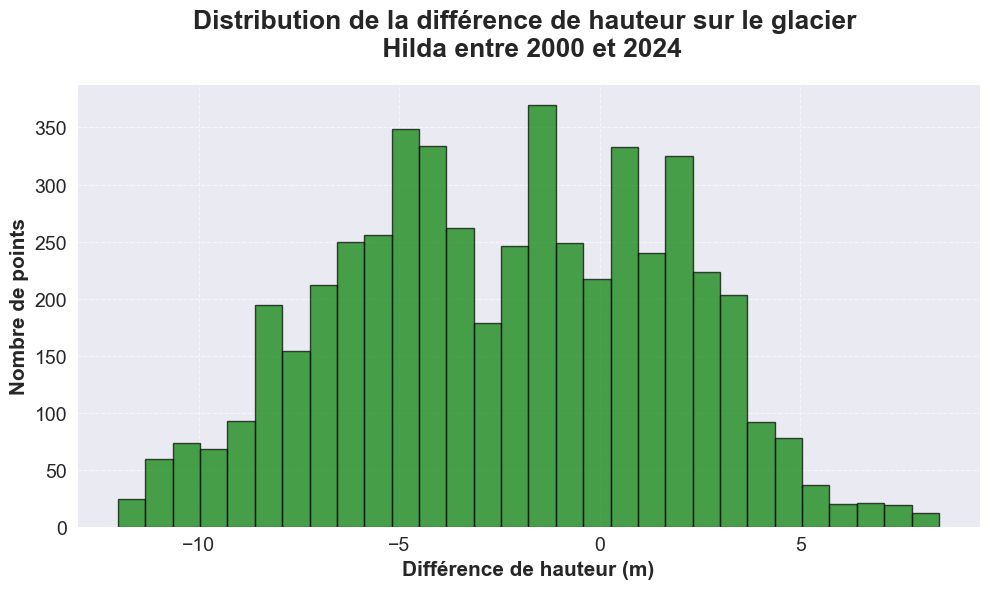

In [10]:
import numpy as np 
import geopandas as gpd
import matplotlib.pyplot as plt
from pyproj import Transformer
from matplotlib.patches import Rectangle

# Charger le fichier shapefile
gdf = gpd.read_file(r"D:\UQTR\Automne 2024\Ouest\GNSS_glaciers\Hilda\roverRS+\Rover\rover_hilda_all.shp")

# Trier les points par une colonne qui peut représenter l'ordre de la ligne, par exemple 'GPST' (données GPS temporelles)
gdf_sorted = gdf.sort_values('GPST')

# Transformer les coordonnées en UTM (zone 12N, par exemple EPSG:32612)
transformer = Transformer.from_crs("EPSG:4326", "EPSG:32612", always_xy=True)
gdf_sorted['utm_x'], gdf_sorted['utm_y'] = transformer.transform(gdf_sorted.geometry.x, gdf_sorted.geometry.y)

# Calculer la distance cumulative entre les points
gdf_sorted['distance'] = np.sqrt((gdf_sorted['utm_x'].diff()**2) + (gdf_sorted['utm_y'].diff()**2))
gdf_sorted['distance_cumulative'] = gdf_sorted['distance'].cumsum().fillna(0)

# Calculer la distance par rapport au front du glacier (point avec id 0)
front_x = gdf_sorted.iloc[0]['utm_x']
front_y = gdf_sorted.iloc[0]['utm_y']
gdf_sorted['distance_from_front'] = np.sqrt((gdf_sorted['utm_x'] - front_x)**2 + (gdf_sorted['utm_y'] - front_y)**2)

# Assurer que les colonnes 'height1' et 'height2' sont présentes
gdf_sorted['height1'] = gdf_sorted['height']
gdf_sorted['height2'] = gdf_sorted['dem_heigh']

# Calculer la différence de hauteur
gdf_sorted['height_diff'] = gdf_sorted['height2'] - gdf_sorted['height1']

# Filtrer les points jusqu'à l'ID 5191 (distance maximale atteinte par le glacier)
gdf_filtered = gdf_sorted.iloc[:5192]

# Tracer l'histogramme de la différence de hauteur
fig, ax = plt.subplots(figsize=(10, 6))

ax.hist(gdf_filtered['height_diff'], bins=30, color='green', alpha=0.7, edgecolor='black')
ax.set_xlabel('Différence de hauteur (m)', fontsize=15, fontweight='bold')
ax.set_ylabel('Nombre de points', fontsize=15, fontweight='bold')
ax.set_title('Distribution de la différence de hauteur sur le glacier \n Hilda entre 2000 et 2024', fontsize=19, fontweight='bold', pad=20)
ax.grid(True, linestyle='--', alpha=0.6)

# Augmenter la police des ticks
ax.tick_params(axis='both', which='major', labelsize=14)

# Ajouter une bordure noire autour du layout sans changer la taille du layout
#fig.patch.set_linewidth(3)
#fig.patch.set_edgecolor('black')

plt.tight_layout()
plt.savefig('height_difference_histogram.png', dpi=300)
plt.show()
